# Logfile Reconstructoin

Reconstructing timestamp using the logfile. We identify the regions of interest, and the UTC times they occur in and then proceed with plugging them back to the data and fixing the time.

In [1]:
# import necessary modules
import matplotlib.pyplot as plt
import raadpy as rp
import numpy as np
import os

# Define some constants
# raw_dir = '../../Data/RAW/'
SD      = '2022-09-07' 
raw_dir = '../../Data/Light-1/light1-'+SD+'/'

# Get the subfiles and put the in a dictionary
fnames      = os.listdir(raw_dir)
filenames   = {}
for i in range(1,10): 
    res = [name for name in fnames if f'buff{i}' in name]
    if len(res)>0: filenames[f'buff{i}'] = res[0]
for name in fnames: 
    if 'log' in name: filenames['log'] = name

print(filenames)

%matplotlib widget

{'buff1': 'light1-2022-09-10-buff1.dat', 'buff2': 'light1-2022-09-07-buff2.dat', 'buff3': 'light1-2022-09-07-buff3.dat', 'buff4': 'light1-2022-09-12-buff4.dat', 'buff5': 'light1-2022-09-13-buff5.dat', 'buff6': 'light1-2022-NA-NA-buff6.dat', 'buff7': 'light1-2022-NA-NA-buff7.dat', 'buff8': 'light1-2022-NA-NA-buff8.dat', 'buff9': 'light1-2022-NA-NA-buff9.dat', 'log': 'light1-2022-09-07-se-log.txt'}


In [2]:
# Directory of the buffer
# buffer_fname    = raw_dir + SD + '/light1-'+SD+'-buff1.dat'
# Or:
buffer_fname    = raw_dir + filenames['buff1']

# Decode the buffer data in a dictionary
data_SiPM   = rp.get_dict(buffer_fname,struct=rp.ORBIT_STRUCT,condition="data['id_bit'] == 1")
data_PMT    = rp.get_dict(buffer_fname,struct=rp.ORBIT_STRUCT,condition="data['id_bit'] == 0")

Line:   0%|          | 0/8534 [00:00<?, ?it/s]

Line:   0%|          | 0/8534 [00:00<?, ?it/s]

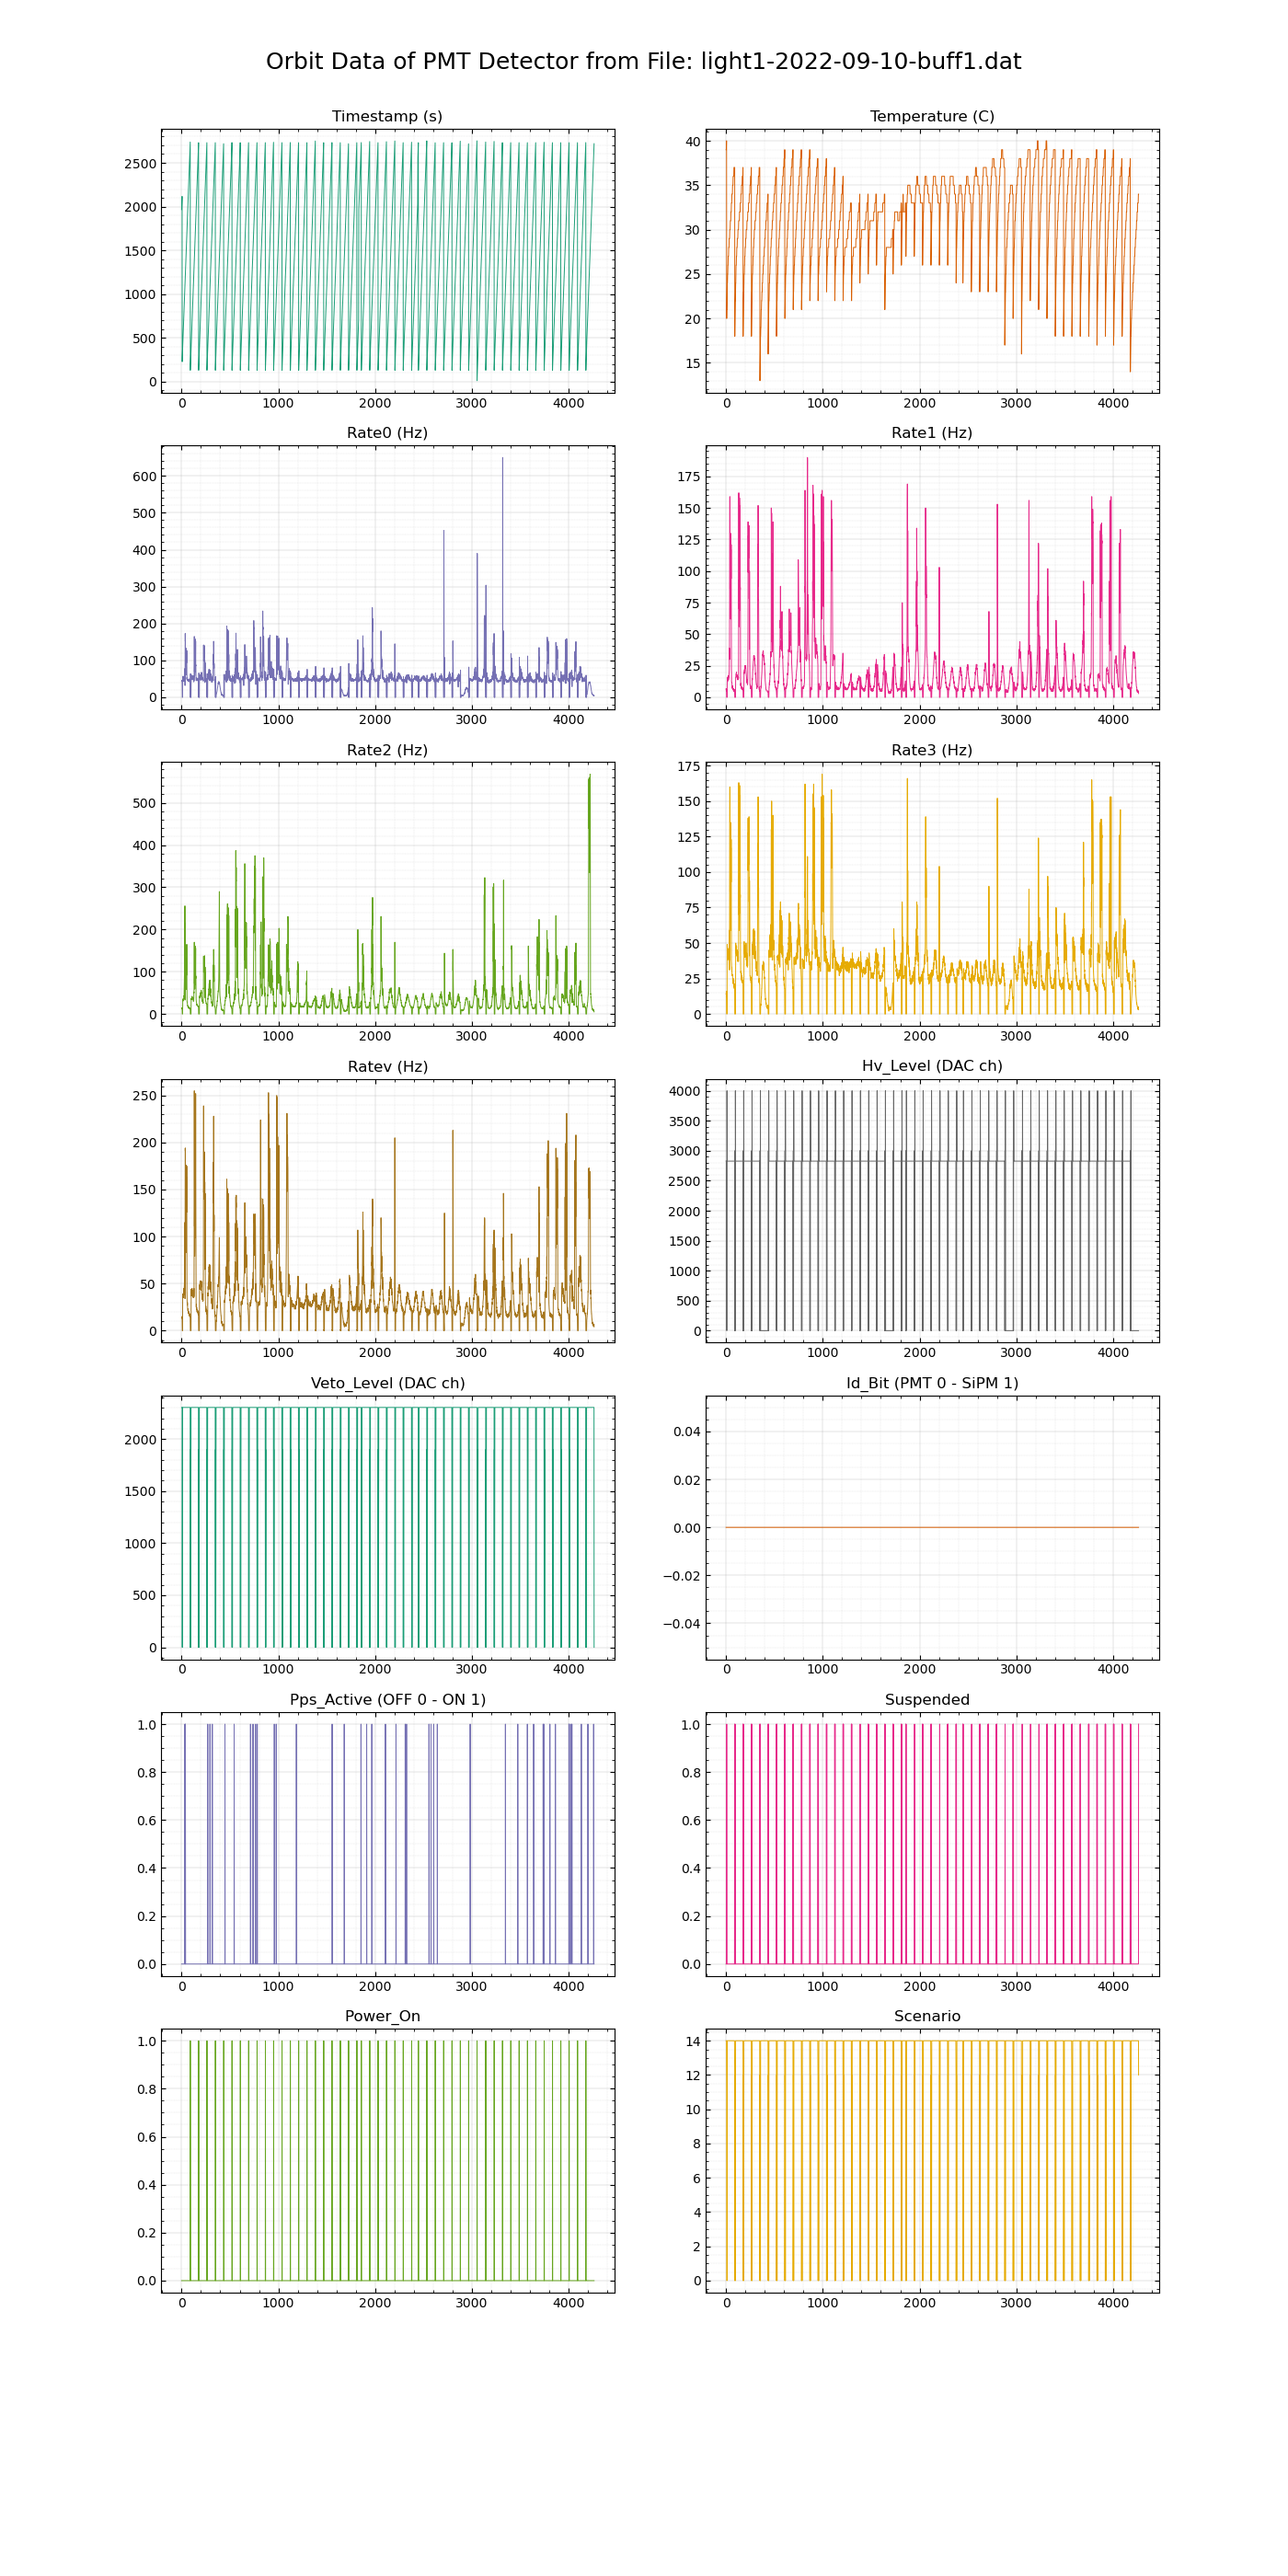

In [3]:
# Now print the PMT Data
fig, axes  = rp.plot_buffer(data_PMT,title = 'Orbit Data of PMT Detector from File: '+ filenames['buff1'],UNITS=rp.ORBIT_UNITS)

In [4]:
# Print the SiPM Data
# fig, axes = rp.plot_buffer(data_SiPM, title = 'Orbit Data of SiPM Detector from File: '+ filenames['buff1'],UNITS=rp.ORBIT_UNITS)

In [5]:
# Now we load the log file and find it's timestamps
log = rp.log_expand(filename=raw_dir+filenames['log'])      # Load the logfile
log = rp.log_with_timestamp(log)                            # Find the timestamp each command finished executing

# Now we want to get only the commands that have anything to do with the scenario
sc_commands = []
PAYLOAD     = rp.SIPM
IGNORE_FAIL = True
for line in log:
    # If you have a custom scenario command
    if f"txrx {PAYLOAD}" in line['command'] or f"txrx {rp.BOTH}" in line['command']:
        # If it was executed correctly
        if IGNORE_FAIL or 'OK\n' in line['output']:
            # Decode the command

            # Append this to the high voltage commands
            sc_commands.append(line)
            try:
                sc_commands[-1]['scenario'] = int(rp.get_cmd_number(line['command']))
            except KeyError:
                print(line['command'])

# Now we can create a high voltage plot as a function of time
scenario = np.array([cmd['scenario']     for cmd in sc_commands])
time     = np.array([cmd['timestamp']    for cmd in sc_commands])

# Now try to align then two 

In [6]:
def trim(array):
    idx = np.where(array[1:] - array[:-1] != 0)[0] 
    return array[idx].astype(int), idx

K = 50
orbit_scenario, orbit_idx = trim(data_SiPM['scenario'])
orbit_scenario            = orbit_scenario[K:]
orbit_idx                 = orbit_idx[K:]
log_scenario, log_idx     = trim(scenario)

FOUND -290
FOUND -283
FOUND -276
FOUND -269
FOUND -262
FOUND -255
FOUND -248
FOUND -241
FOUND -234
FOUND -227
FOUND -220
FOUND -213
FOUND 3


Text(0, 0.5, 'Fraction of Mistakenly aligned log')

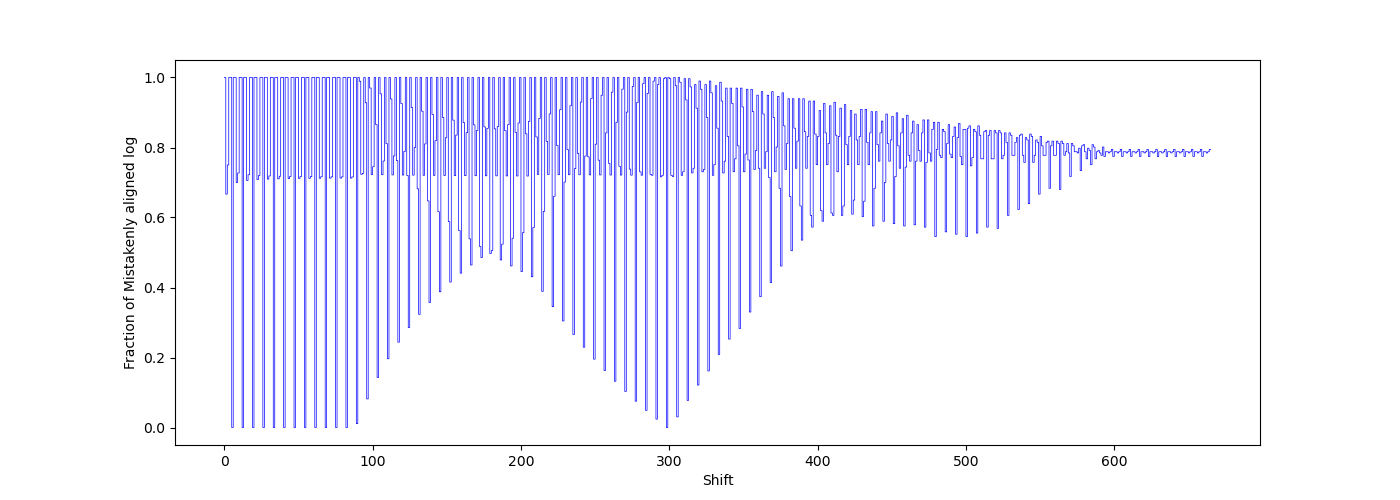

In [7]:
N = len(orbit_scenario)
selected = 0
mistakes = []
for i in range(-N+1,len(log_scenario)-N):
    n = min(i+N,N)
    if len(log_scenario[max(i,0):max(i,0)+n]) != len(orbit_scenario[N-n:]): 
        print(i,n,len(log_scenario[max(i,0):max(i,0)+n]),len(orbit_scenario[N-n:]))

    mistakes.append(np.sum(~(log_scenario[max(i,0):max(i,0)+n] == orbit_scenario[N-n:]))/n)
    if mistakes[-1] == 0:
        selected = i
        print('FOUND '+str(i))

mistakes = np.array(mistakes)
plt.figure(figsize=(14,5))
plt.step(range(len(mistakes)),mistakes,c='blue',lw=0.5);
plt.xlabel('Shift')
plt.ylabel('Fraction of Mistakenly aligned log')

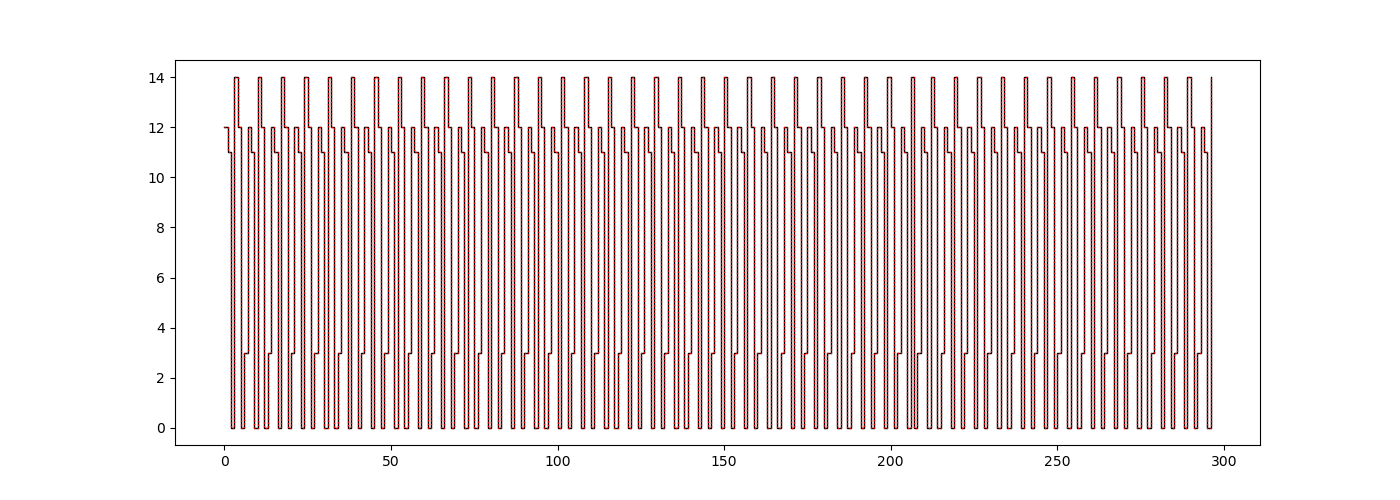

In [8]:
plt.figure(figsize=(14,5))

I =  selected
nums = list(range(N))
plt.step(nums,orbit_scenario,where='post',c='k',lw=1)
plt.step(nums,log_scenario[I:I+N],where='post',c='r',lw=1,ls=':')

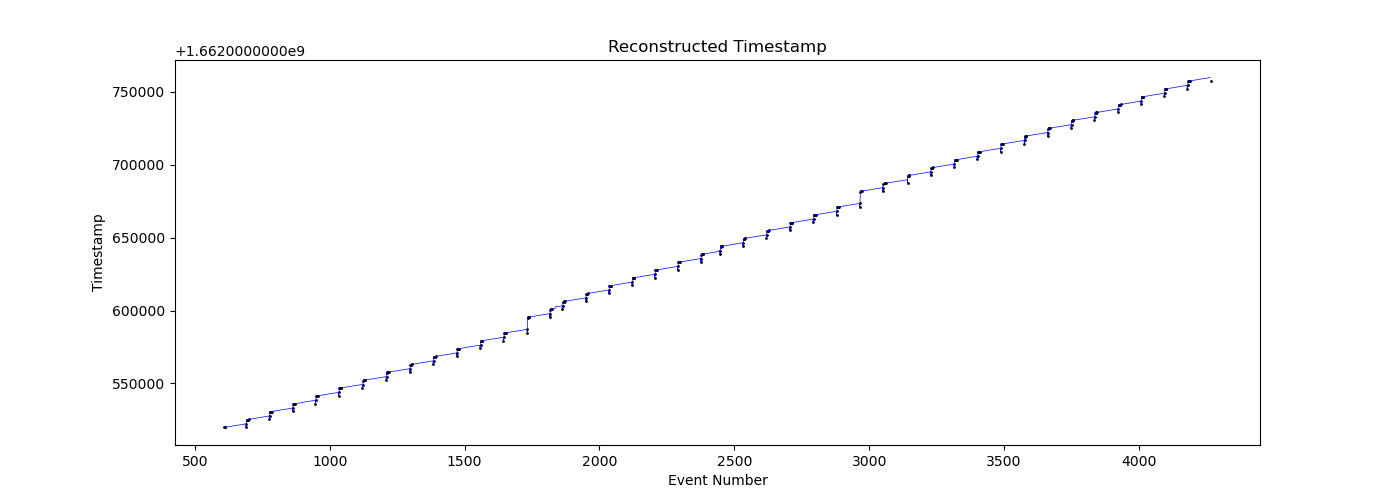

In [9]:
# PUT BACK THE TIMESTAMPS
time_orbit = time[log_idx[I:I+N]]

# Create a timestamp array for the in-between indices based on the plot timestamp
time_event = []
for i in range(min(orbit_idx),max(orbit_idx)):
    if i in orbit_idx: time_event.append(time_orbit[np.where(orbit_idx == i)[0][0]])
    else:
        # close, close_idx = rp.find_closest(i,orbit_idx,return_idx=True)
        # time_event.append(np.interp(i,close,time_orbit[list(close_idx)]))
        dt = data_SiPM['timestamp'][i] - data_SiPM['timestamp'][i-1]
        time_event.append(time_event[-1] + dt)

time_event = np.array(time_event)

plt.figure(figsize=(14,5))
plt.plot(range(min(orbit_idx),max(orbit_idx)),time_event,c='blue',lw=0.5)
plt.scatter(orbit_idx,time_orbit,c='k',s=1)
plt.xlabel('Event Number')
plt.ylabel('Timestamp')
plt.title('Reconstructed Timestamp');

In [10]:
# Convert to astropy object time
MIN = rp.Time('2022-09-09T00:00:00Z',format = 'isot').to_value(format='unix')
MAX = rp.Time('2022-09-09T23:59:59Z',format = 'isot').to_value(format='unix')

time_astro = [rp.Time(t,format='unix') for t in time_event]# if  MIN <= t <= MAX]
print(len(time_astro))

# Get the location of the cubesat in this time
positions = rp.get_light1_position(min(time_astro),max(time_astro),n_events=10*len(time_astro))

3657


In [11]:
# Interpolate positions
def interpolate(array,timestamps):
    new_array   = rp.array([])
    old_time    = array.get_timestamps(format='unix')
    longs,lats  = array.get_coords().T
    for t in timestamps:
        new_array.append(rp.event(
            timestamp = rp.Time(t,format='unix'),
            latitude  = np.interp(t,old_time,lats),
            longitude = np.interp(t,old_time,longs),
            detector_id=0,
        ))


    return new_array

positions = interpolate(positions,time_event)

In [12]:
rates = 0
for i in range(4):
    rates += data_SiPM[f'rate{i}'][range(min(orbit_idx),max(orbit_idx))]

log_rates = np.array([2*max(0,np.log(r)) for r in rates])

rp.map(positions,color=rates,marker_size=log_rates,size=800)

